# Demystifying: Machine Learning

https://www.optica.org/events/congress/advanced_photonics_congress/program/demystifying/

Carlos Natalino $^1$ and Ben Mills $^2$

$^1$ Department of Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden. https://www.chalmers.se/en/persons/carda/

$^2$ University of Southampton, Southampton, UK. https://www.southampton.ac.uk/people/5x7lvp/doctor-ben-mills

## Part 1.2: Applying supervised learning for performance prediction and estimation

General links can be found here: https://github.com/carlosnatalino/demystifying-ml/

### Step 1: setup environment, import relevant libraries and files

In [3]:
# Here we concentrate all the imports
import random
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn.metrics as skmetrics

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [4]:
sys.version

'3.12.4 (main, Jun  6 2024, 18:26:44) [Clang 15.0.0 (clang-1500.3.9.4)]'

In [5]:
import matplotlib
matplotlib.__version__

'3.9.1'

In [6]:
pd.__version__

'2.2.2'

In [7]:
requests.__version__

'2.32.3'

In [8]:
import sklearn
sklearn.__version__

'1.5.1'

In [9]:
# Here we list the files that are within the folder.
os.makedirs("./figures", exist_ok=True)
os.makedirs("./downloads", exist_ok=True)
if not os.path.exists("./downloads/nobel-eu_200_initial_dataset.csv"):
    with open("./downloads/nobel-eu_200_initial_dataset.csv", "wt", encoding="utf-8") as file:
        content = requests.get("https://github.com/carlosnatalino/demystifying-ml/raw/main/datasets/nobel-eu_200_initial_dataset.csv")
        file.write(content.text)
os.listdir("./downloads")

['service_1002_data.csv', 'nobel-eu_200_initial_dataset.csv']

In [10]:
# Setting seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [11]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    #"cpu"
)
print(f"Using {device} device")

Using mps device


### Step 2: load the data

In [12]:
data_qot = pd.read_csv("./downloads/nobel-eu_200_initial_dataset.csv", index_col=0)
data_qot.describe()

,source_id,source_degree,destination_id,destination_degree,path_length,mean_link_length,min_link_length,max_link_length,std_link_length,number_hops,...,bit_rate,bandwidth,GSNR,ASE,NLI,margin,mean_link_usage,min_link_usage,max_link_usage,std_link_usage
count,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,...,95518.000000,9.551800e+04,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000,95518.000000
mean,13.528424,2.954857,13.620490,2.947947,1583.990281,457.281210,306.756397,625.310945,126.410997,3.509443,...,125.598526,4.803741e+10,17.384867,18.800307,28.050723,3.521216,0.743527,0.633601,0.842637,0.082332
std,8.085343,0.845148,8.081808,0.840862,802.241614,126.706851,143.627008,204.460355,86.644056,1.627602,...,147.776125,6.464102e+10,4.359600,5.086228,6.991483,1.431692,0.093699,0.141762,0.092153,0.053663
min,0.000000,2.000000,0.000000,2.000000,157.685000,157.685000,157.685000,157.685000,0.000000,1.000000,...,10.000000,1.250000e+10,3.983312,3.983744,15.941123,0.264055,0.287500,0.256250,0.287500,0.000000
25%,6.000000,2.000000,7.000000,2.000000,945.095000,384.432333,215.887000,519.156000,74.305500,2.000000,...,10.000000,1.250000e+10,15.661842,16.433287,22.675202,2.644396,0.681250,0.525000,0.790625,0.040172
50%,14.000000,3.000000,14.000000,3.000000,1500.154000,438.630500,271.182000,584.226000,126.302903,3.000000,...,40.000000,1.250000e+10,17.859917,19.630077,26.150153,3.480484,0.740625,0.623437,0.856250,0.082812
75%,20.000000,3.000000,21.000000,3.000000,2086.724000,520.891800,350.553000,708.738000,164.618600,5.000000,...,100.000000,3.750000e+10,20.135566,22.182579,31.218869,4.450121,0.806250,0.737500,0.909375,0.121941
max,27.000000,5.000000,27.000000,5.000000,4227.992000,1306.436000,1306.436000,1306.436000,454.922422,8.000000,...,400.000000,4.000000e+11,29.893781,32.101415,44.805517,10.880316,0.996875,0.996875,0.996875,0.303125


In [13]:
input_features = [
    'source_id', 'source_degree', 'destination_id', 'destination_degree',
    'path_length', 'mean_link_length', 'min_link_length', 'max_link_length',
    'std_link_length', 'number_hops', 'number_spans', 'center_frequency',
    'bit_rate', "bandwidth",
    'mean_link_usage', 'min_link_usage', 'max_link_usage', 'std_link_usage']

label = ['GSNR'] #, 'ASE', 'NLI', 'margin'

### Step 3: Training a decision tree

In this example, we show that a simple decision tree can achieve fairly good results.

#### Prepare for training

Here we divide the dataset into two subsets, one for training, and one for testing.
You can control the portion used for training and testing with the `train_size` parameter.

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(data_qot[input_features], data_qot[label], random_state=seed, train_size=.5)

#### Training the model

In [15]:
clf = tree.DecisionTreeRegressor()  # create the model object
clf = clf.fit(X_train, Y_train)  # fit it to the training data

In [16]:
# get prediction of the training dataset
y_train_pred_tree = clf.predict(X_train)

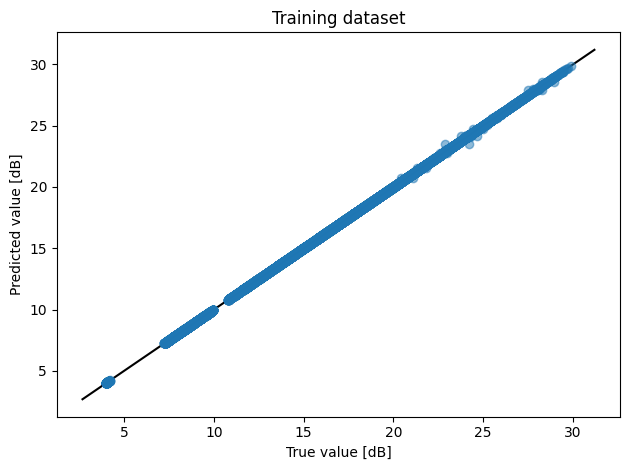

In [17]:
# plot true vs. predicted value
plt.figure()
plt.scatter(Y_train, y_train_pred_tree, alpha=0.5, zorder=2)

plt.plot(plt.xlim(), plt.xlim(), color="black", zorder=1)

plt.title("Training dataset")
plt.xlabel("True value [dB]")
plt.ylabel("Predicted value [dB]")

plt.tight_layout()

plt.savefig("figures/tree_training_true_vs_pred.png")

plt.show()

#### Test the model

Here we assess the performance of the model on the testing (unseen) data

In [18]:
y_test_pred_tree = clf.predict(X_test)

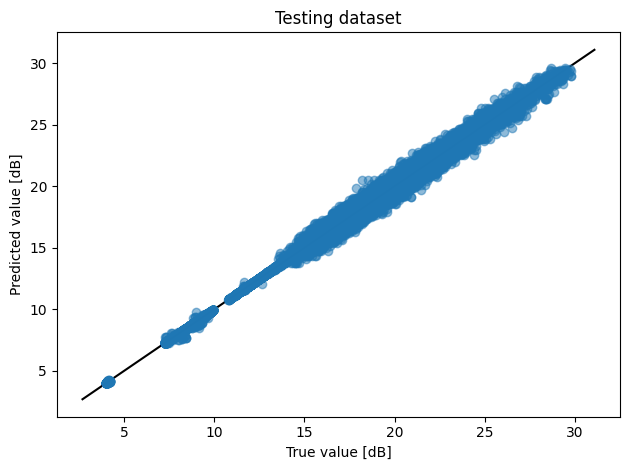

In [19]:
plt.figure()
plt.scatter(Y_test, y_test_pred_tree, alpha=0.5, zorder=2)

plt.plot(plt.xlim(), plt.xlim(), color="black", zorder=1)

plt.title("Testing dataset")
plt.xlabel("True value [dB]")
plt.ylabel("Predicted value [dB]")

plt.tight_layout()

# plt.savefig("figures/tree_testing_true_vs_pred.png")

plt.show()

#### Evaluate the model

In [20]:
print("Metric\tTrain\t\t\tTest")
print("MAE:   ", skmetrics.mean_absolute_error(Y_train, y_train_pred_tree), "\t", skmetrics.mean_absolute_error(Y_test, y_test_pred_tree))
print("MSE:   ", skmetrics.mean_squared_error(Y_train, y_train_pred_tree), "\t", skmetrics.mean_squared_error(Y_test, y_test_pred_tree))
print("MAPE:  ", skmetrics.mean_absolute_percentage_error(Y_train, y_train_pred_tree), "\t", skmetrics.mean_absolute_percentage_error(Y_test, y_test_pred_tree))
print("RMSE:  ", skmetrics.mean_squared_error(Y_train, y_train_pred_tree, squared=True), "\t", skmetrics.mean_squared_error(Y_test, y_test_pred_tree, squared=True))
print("R2:    ", skmetrics.r2_score(Y_train, y_train_pred_tree), "\t", skmetrics.r2_score(Y_test, y_test_pred_tree))

Metric	Train			Test
MAE:    0.00024085400812197063 	 0.18440270732328903
MSE:    6.122987250800562e-05 	 0.09058611457817511
MAPE:   9.862853410234206e-06 	 0.00969813514695693
RMSE:   6.122987250800562e-05 	 0.09058611457817511
R2:     0.9999967720441006 	 0.9952430551582565


/Users/carda/projects/demystifying-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/carda/projects/demystifying-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


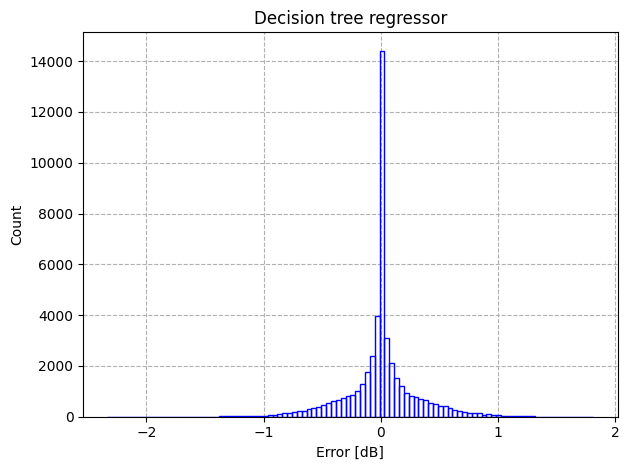

In [21]:
# histogram of the error
error_tree = Y_test.to_numpy().squeeze() - y_test_pred_tree
plt.figure()
plt.hist(error_tree, bins=100, zorder=10, facecolor=(0, 0, 0, 0), edgecolor="blue")
plt.grid(which="both", axis="both", zorder=5, ls="--")
plt.title("Decision tree regressor")
plt.xlabel("Error [dB]")
plt.ylabel("Count")
plt.tight_layout()
# plt.savefig("figures/tree_testing_error_histogram.png")
plt.show()

### Step 4: Training an artificial neural network

In this part of the code, we build and train an artificial neural network.

In [63]:
# the `scale` variable defines whether or not the standard scaler will be applied to the dataset.
scale = True
# scale = False

In [64]:
if scale:
    X_scaler_qot = preprocessing.StandardScaler().fit(data_qot[input_features])
    Y_scaler_qot = preprocessing.StandardScaler().fit(data_qot[label].to_numpy().reshape((-1, 1)))
    
    X_train_scaled = X_scaler_qot.transform(X_train)
    Y_train_scaled = Y_scaler_qot.transform(Y_train)
    X_test_scaled = X_scaler_qot.transform(X_test)
    Y_test_scaled = Y_scaler_qot.transform(Y_test)

else:
    X_train_scaled = X_train
    Y_train_scaled = Y_train
    X_test_scaled = X_test
    Y_test_scaled = Y_test

/Users/carda/projects/demystifying-ml/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/carda/projects/demystifying-ml/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Prepare for training


In [65]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = np.float32(x)
        self.y = np.float32(y)

    def __getitem__(self, index: int):
        return self.x[index, :], self.y[index]

    def __len__(self):
        return self.x.shape[0]

In [66]:
loss_fn = nn.MSELoss()
batch_size = 64  # feel free to modify this parameter if needed

training_data = CustomDataset(x=X_train_scaled, y=Y_train_scaled)
test_data = CustomDataset(x=X_test_scaled, y=Y_test_scaled)

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C]: torch.Size([64, 18])
Shape of y: torch.Size([64, 1]) torch.float32


In [67]:
# Define the ANN model and architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            # uncomment the two lines below if you want a deeper ANN
            # nn.Linear(256, 256),
            # nn.ReLU(),
            nn.Linear(256, 1),
        )


    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(X_train.shape[1]).to(device)
print(model)
epochs = 50
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

# Calculate the number of weights in the model
nweights = 0
for name,weights in model.named_parameters():
    if 'bias' not in name:
        nweights = nweights + weights.numel()
print(f'Total number of trainable parameters in the model = {nweights}')

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
Total number of trainable parameters in the model = 70400


In [68]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    total_loss = 0
    mse = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        model.zero_grad()

        y = y.view((len(y), 1))

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()

        mse += ((pred -  y) * (pred -  y)).float().sum()

        loss, current = loss.item(), (batch + 1) * len(X)
        total_loss += loss
        # if batch % 100 == 0:
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches
    mse /= size

    print(f"Train Error - MSE: {(100*mse):>0.2f}, Avg loss: {total_loss:>8f}")
    return total_loss, mse

In [69]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    mse = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.view((len(y), 1))
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            mse += ((pred -  y) * (pred -  y)).float().sum()

    test_loss /= num_batches
    mse /= size

    print(f"Test Error -  MSE: {(100*mse):>0.2f}, Avg loss: {test_loss:>8f}")
    return test_loss, mse

#### Train the model

In [70]:
history_training_loss = []
history_testing_loss = []
history_training_mse = []
history_testing_mse = []
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    epoch_loss, mse = train(train_dataloader, model, loss_fn, optimizer)
    history_training_loss.append(epoch_loss)
    history_training_mse.append(mse)
    test_loss, mse = test(test_dataloader, model, loss_fn)
    history_testing_loss.append(test_loss)
    history_testing_mse.append(mse)
print("Done!")


Epoch 1
-------------------------------
Train Error - MSE: 2.00, Avg loss: 0.020039
Test Error -  MSE: 2.05, Avg loss: 0.020545

Epoch 2
-------------------------------
Train Error - MSE: 0.98, Avg loss: 0.009795
Test Error -  MSE: 1.85, Avg loss: 0.018547

Epoch 3
-------------------------------
Train Error - MSE: 0.78, Avg loss: 0.007796
Test Error -  MSE: 1.69, Avg loss: 0.016897

Epoch 4
-------------------------------
Train Error - MSE: 0.67, Avg loss: 0.006710
Test Error -  MSE: 1.37, Avg loss: 0.013661

Epoch 5
-------------------------------
Train Error - MSE: 0.60, Avg loss: 0.006042
Test Error -  MSE: 1.04, Avg loss: 0.010413

Epoch 6
-------------------------------
Train Error - MSE: 0.56, Avg loss: 0.005577
Test Error -  MSE: 1.01, Avg loss: 0.010051

Epoch 7
-------------------------------
Train Error - MSE: 0.52, Avg loss: 0.005186
Test Error -  MSE: 0.77, Avg loss: 0.007703

Epoch 8
-------------------------------
Train Error - MSE: 0.49, Avg loss: 0.004897
Test Error -

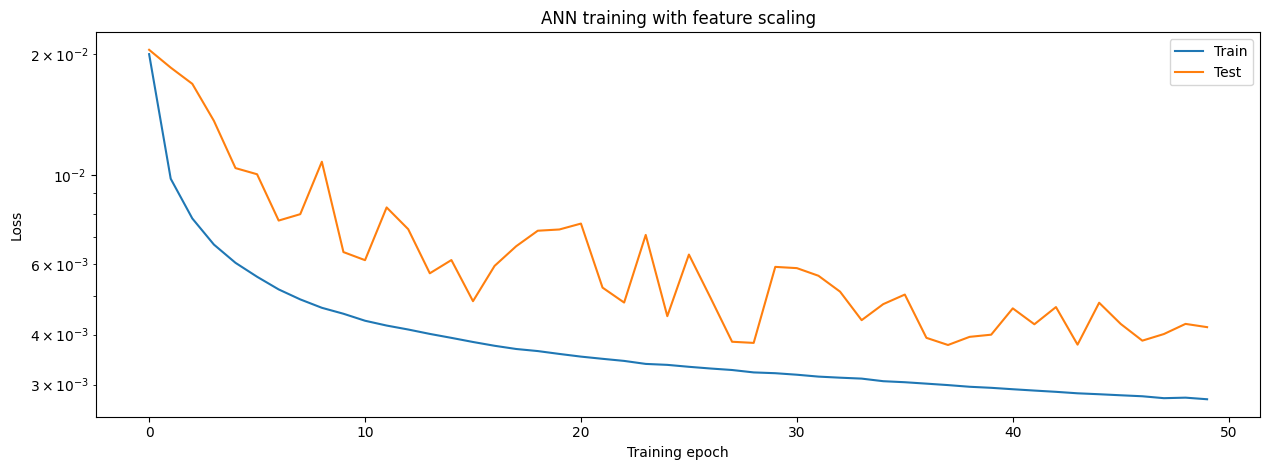

In [71]:
plt.figure(figsize=(12.8, 4.8))

plt.semilogy(history_training_loss, label="Train")
plt.semilogy(history_testing_loss, label="Test")
plt.title(f"ANN training {'with' if scale else 'without'} feature scaling")
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

# plt.savefig(f"figures/ann_history_training_loss.png")
plt.show()

In [72]:
y_train = []
y_train_pred_ann = []
with torch.no_grad():
    for X, y in train_dataloader:
        X = X.to(device)
        pred = model(X)
        if scale:
          actual = Y_scaler_qot.inverse_transform(y.reshape((-1, 1)))
        else:
          actual = y
        y_train.extend(actual[:, 0])
        if scale:
          predicted = Y_scaler_qot.inverse_transform(pred.cpu().numpy())
        else:
          predicted = pred.cpu().numpy()
        y_train_pred_ann.extend(predicted[:, 0])

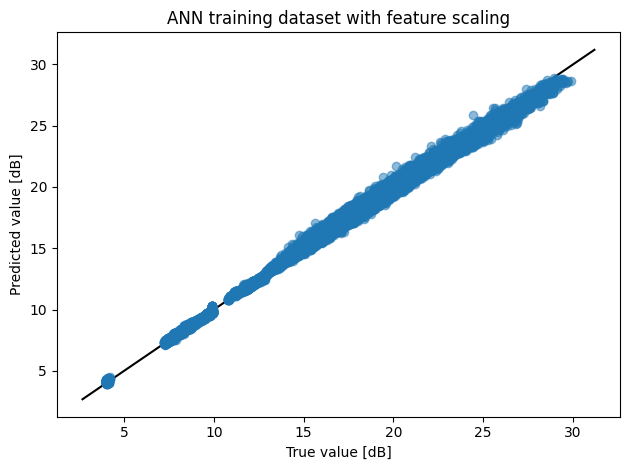

In [73]:
plt.figure()
plt.scatter(y_train, y_train_pred_ann, alpha=0.5, zorder=2)

plt.plot(plt.xlim(), plt.xlim(), color="black", zorder=1)

plt.title(f"ANN training dataset {'with' if scale else 'without'} feature scaling")
plt.xlabel("True value [dB]")
plt.ylabel("Predicted value [dB]")

plt.tight_layout()

# plt.savefig(f"figures/ann_training_true_vs_pred.png")

plt.show()

#### Test the model

In [74]:
y_test = []
y_test_pred_ann = []
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        pred = model(X)
        if scale:
          actual = Y_scaler_qot.inverse_transform(y.reshape((-1, 1)))
        else:
          actual = y
        y_test.extend(actual[:, 0])
        if scale:
          predicted = Y_scaler_qot.inverse_transform(pred.cpu().numpy())
        else:
          predicted = pred.cpu().numpy()
        y_test_pred_ann.extend(predicted[:, 0])

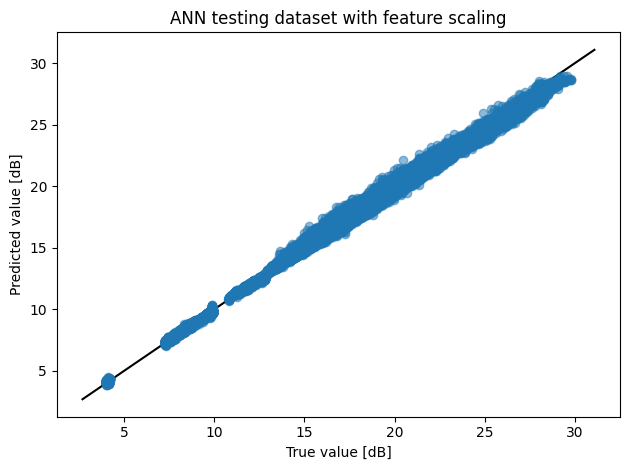

In [75]:
plt.figure()
plt.scatter(y_test, y_test_pred_ann, alpha=0.5, zorder=2)

plt.plot(plt.xlim(), plt.xlim(), color="black", zorder=1)

plt.title(f"ANN testing dataset {'with' if scale else 'without'} feature scaling")
plt.xlabel("True value [dB]")
plt.ylabel("Predicted value [dB]")

plt.tight_layout()

# plt.savefig(f"figures/ann_test_true_vs_pred.png")

plt.show()

#### Evaluate the model

In [76]:
print("Metric\tTrain\t\t\tTest")
print("MAE:   ", skmetrics.mean_absolute_error(y_train, y_train_pred_ann), "\t", skmetrics.mean_absolute_error(y_test, y_test_pred_ann))
print("MSE:   ", skmetrics.mean_squared_error(y_train, y_train_pred_ann), "\t", skmetrics.mean_squared_error(y_test, y_test_pred_ann))
print("MAPE:  ", skmetrics.mean_absolute_percentage_error(y_train, y_train_pred_ann), "\t", skmetrics.mean_absolute_percentage_error(y_test, y_test_pred_ann))
print("RMSE:  ", skmetrics.mean_squared_error(y_train, y_train_pred_ann, squared=True), "\t", skmetrics.mean_squared_error(y_test, y_test_pred_ann, squared=True))
print("R2:    ", skmetrics.r2_score(y_train, y_train_pred_ann), "\t", skmetrics.r2_score(y_test, y_test_pred_ann))

Metric	Train			Test
MAE:    0.19058222661148982 	 0.20369704709137623
MSE:    0.06914930483259003 	 0.0793540009624276
MAPE:   0.010587412654131372 	 0.011268447939026543
RMSE:   0.06914930483259003 	 0.0793540009624276
R2:     0.996354542358833 	 0.9958328866696758


/Users/carda/projects/demystifying-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/carda/projects/demystifying-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


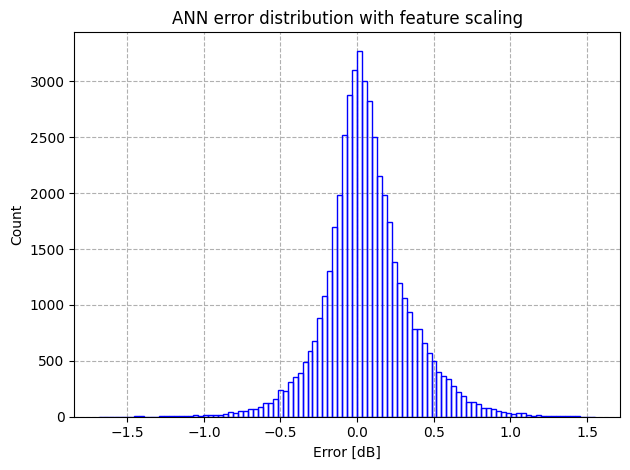

In [77]:
# histogram of the error
error_ann = np.array(y_test) - np.array(y_test_pred_ann)
plt.figure()

plt.hist(error_ann, bins=100, zorder=10, facecolor=(0, 0, 0, 0), edgecolor="blue")
plt.grid(which="both", axis="both", zorder=5, ls="--")
plt.title(f"ANN error distribution {'with' if scale else 'without'} feature scaling")
plt.xlabel("Error [dB]")
plt.ylabel("Count")
plt.tight_layout()
# plt.savefig("figures/ann_testing_error_histogram.png")
plt.show()

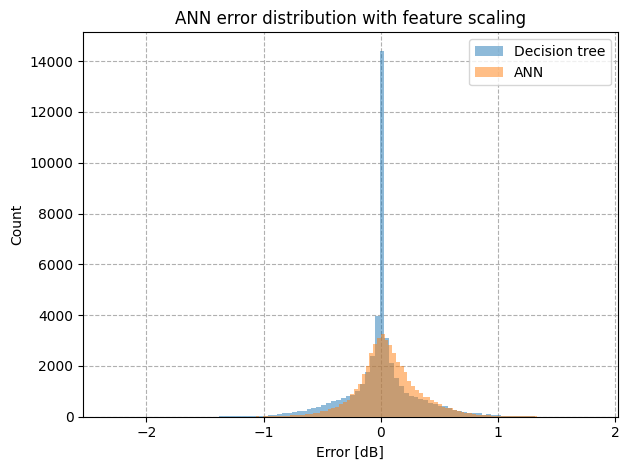

In [78]:
# histogram of the error
plt.figure()

plt.hist(error_tree, bins=100, zorder=10, alpha=0.5, label="Decision tree")
plt.hist(error_ann, bins=100, zorder=10, alpha=0.5, label="ANN")
plt.grid(which="both", axis="both", zorder=5, ls="--")
plt.title(f"ANN error distribution {'with' if scale else 'without'} feature scaling")
plt.xlabel("Error [dB]")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
# plt.savefig("figures/testing_error_histogram.png")
plt.show()